# Data model matching using mean square error

Required libraries, some constants and generated pulses

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random as rand
from itertools import combinations
import matplotlib.patches as mpatches

PLOT_ROWS = 3
PLOT_CELLS = 2
DATA_MIN_VAL = 0.5
DATA_MAX_VAL = 1
DEV_LINE_FUNC = 0.3  # deviation from line function

def get_random_data(points_qty=10) -> (np.array, np.array):
    x_values = rand.sample(range(int(DATA_MIN_VAL * 100), int(DATA_MAX_VAL * 100)), points_qty)
    x_values.sort()
    x = np.empty([len(x_values), 1])
    for i in range(len(x_values)):
        x[i, 0] = x_values[i] / 100

    y = np.empty([len(x_values), 1])
    for i in range(len(x_values)):
        y[i, 0] = rand.uniform(x[i, 0] - DEV_LINE_FUNC / 2, x[i, 0] + DEV_LINE_FUNC)
    return x, y

data = get_random_data()

Calculating models

In [2]:
def calculate_Qa(data_x, data_y, degree):
    X = design_matrix(data_x, degree).transpose()
    Y = data_y.transpose()
    a, _ = least_squares(data_x, data_y, degree)
    return ((Y - a.transpose() @ X) @ (Y - a.transpose() @ X).transpose())[0][0]


def calculate_Qa_regularization(data_x, data_y, degree, lamb):
    X = design_matrix(data_x, degree).transpose()
    Y = data_y.transpose()
    a, _ = regularized_least_squares(data_x, data_y, degree, lamb)
    return ((Y - a.transpose() @ X) @ (Y - a.transpose() @ X).transpose() + lamb * (a.transpose() @ a))[0][0]


def polynomial(x, w):
    dm = [w[i] * x ** i for i in range(np.shape(w)[0])]
    return np.sum(dm, axis=0)


def design_matrix(x_train, degree):
    return np.array([x_train ** i for i in range(degree + 1)]).transpose()[0]


def mean_squared_error(x, y, w):
    N = np.shape(x)[0]
    return 1 / N * np.sum((y - polynomial(x, w)) ** 2)


def least_squares(x_train, y_train, degree):
    design = design_matrix(x_train, degree)
    w = np.linalg.inv(design.transpose() @ design) @ design.transpose() @ y_train
    return w, mean_squared_error(x_train, y_train, w)


def regularized_least_squares(x_train, y_train, degree, regularization_lambda):
    design = design_matrix(x_train, degree)
    w = np.linalg.inv(
        design.transpose() @ design + regularization_lambda * np.eye(degree + 1)) @ design.transpose() @ y_train
    return w, mean_squared_error(x_train, y_train, w)


def calculate_min_param_for_regularized(data, degree, lambdas):
    param_err = [regularized_least_squares(data[0], data[1], degree, lamb) for lamb in lambdas]
    min_err = param_err[0][1]
    param = param_err[0][0]
    best_lambda = lambdas[0]
    for i in range(len(param_err)):
        tup = param_err[i]
        if tup[1] < min_err:
            min_err = tup[1]
            param = tup[0]
            best_lambda = lambdas[i]
    return param, best_lambda


def data_debased_by_2_param(x_data, y_data):
    comb = combinations(np.arange(0, x_data.shape[0]).tolist(), 2)
    x_data_list = []
    for i in list(comb):
        x = np.delete(x_data, i[0], axis=0)
        y = np.delete(y_data, i[0], axis=0)
        x = np.delete(x, i[1] - 1, axis=0)
        y = np.delete(y, i[1] - 1, axis=0)
        x_data_list.append((x, y))
    return x_data_list

Drawing plots

In [3]:
def plot_result_cell(start_data, degree, plot_x_vals, plot_row, plot_col, lambdas):
    ax[plot_row][plot_col].set_ylim(-0.5, (DATA_MAX_VAL + DEV_LINE_FUNC) * 1.5)

    # plot debased model
    debased_data = data_debased_by_2_param(start_data[0], start_data[1])
    for deb_data in debased_data:
        if lambdas is not None:
            param, _ = calculate_min_param_for_regularized(deb_data, degree, lambdas)
        else:
            param, _ = least_squares(deb_data[0], deb_data[1], degree)
        y = polynomial(plot_x_vals, param)
        ax[plot_row][plot_col].plot(plot_x_vals, y, "orange", linewidth=1)

    # plot correct model
    if lambdas is not None:
        param, lamb = calculate_min_param_for_regularized(start_data, degree, lambdas)
    else:
        param, _ = least_squares(start_data[0], start_data[1], degree)
    y = polynomial(plot_x_vals, param)
    ax[plot_row][plot_col].plot(plot_x_vals, y, "black", linewidth=2)

    # plot points
    ax[plot_row][plot_col].plot(start_data[0], start_data[1], "b o")

    # calculate quality assurance and euclidean domain\
    if lambdas is None:
        qa = calculate_Qa(start_data[0], start_data[1], degree)
        lambdas_title = ""
    else:
        qa = calculate_Qa_regularization(start_data[0], start_data[1], degree, lamb)
        lambdas_title = "$\lambda$= " + lamb.__str__()
    # plot labels
    quantity_title = "\n\n\n\nParameters quantity: " + (degree + 1).__str__()
    quality_title = "Quality assurance (Qa): " + round(qa, 6).__str__()
    title = quantity_title + "\n" + quality_title + "\n" + lambdas_title
    ax[plot_row][plot_col].set_title(title)
    ax[plot_row][plot_col].legend(handles=[orange_patch, black_patch])


def plot_compare_results(started_data, lambdas=None):
    if lambdas is None:
        title = "Data model matching using mean square error"
    else:
        title = "Data model matching using mean square error with regularization"
    fig.suptitle(title, fontsize=20, weight="bold")
    x_plot_data = np.arange(min(data[0]), max(data[0]), 0.001)
    row = -1
    for i in range(PLOT_CELLS * PLOT_ROWS):
        col = i % PLOT_CELLS
        if col == 0:
            row += 1
        plot_result_cell(started_data, i + 1, x_plot_data, row, col, lambdas)

## Without regularization

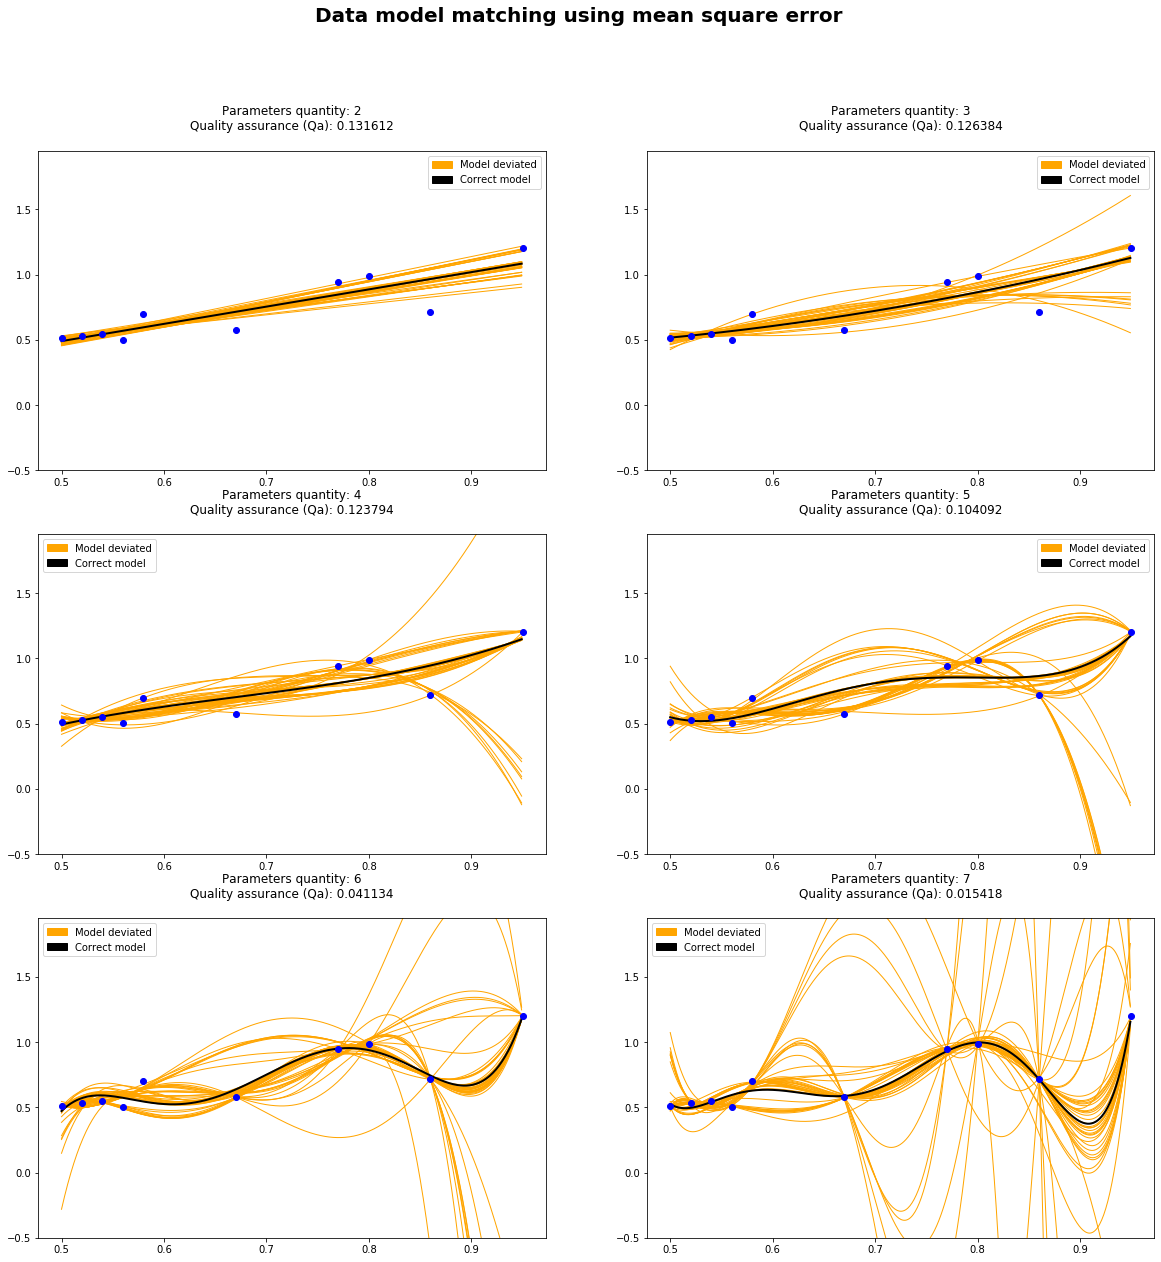

In [4]:
fig, ax = plt.subplots(nrows=PLOT_ROWS, ncols=PLOT_CELLS, figsize=(20, 20))
orange_patch = mpatches.Patch(color='orange', label='Model deviated')
black_patch = mpatches.Patch(color='black', label='Correct model')

plot_compare_results(data)
plt.show()

## With regularization

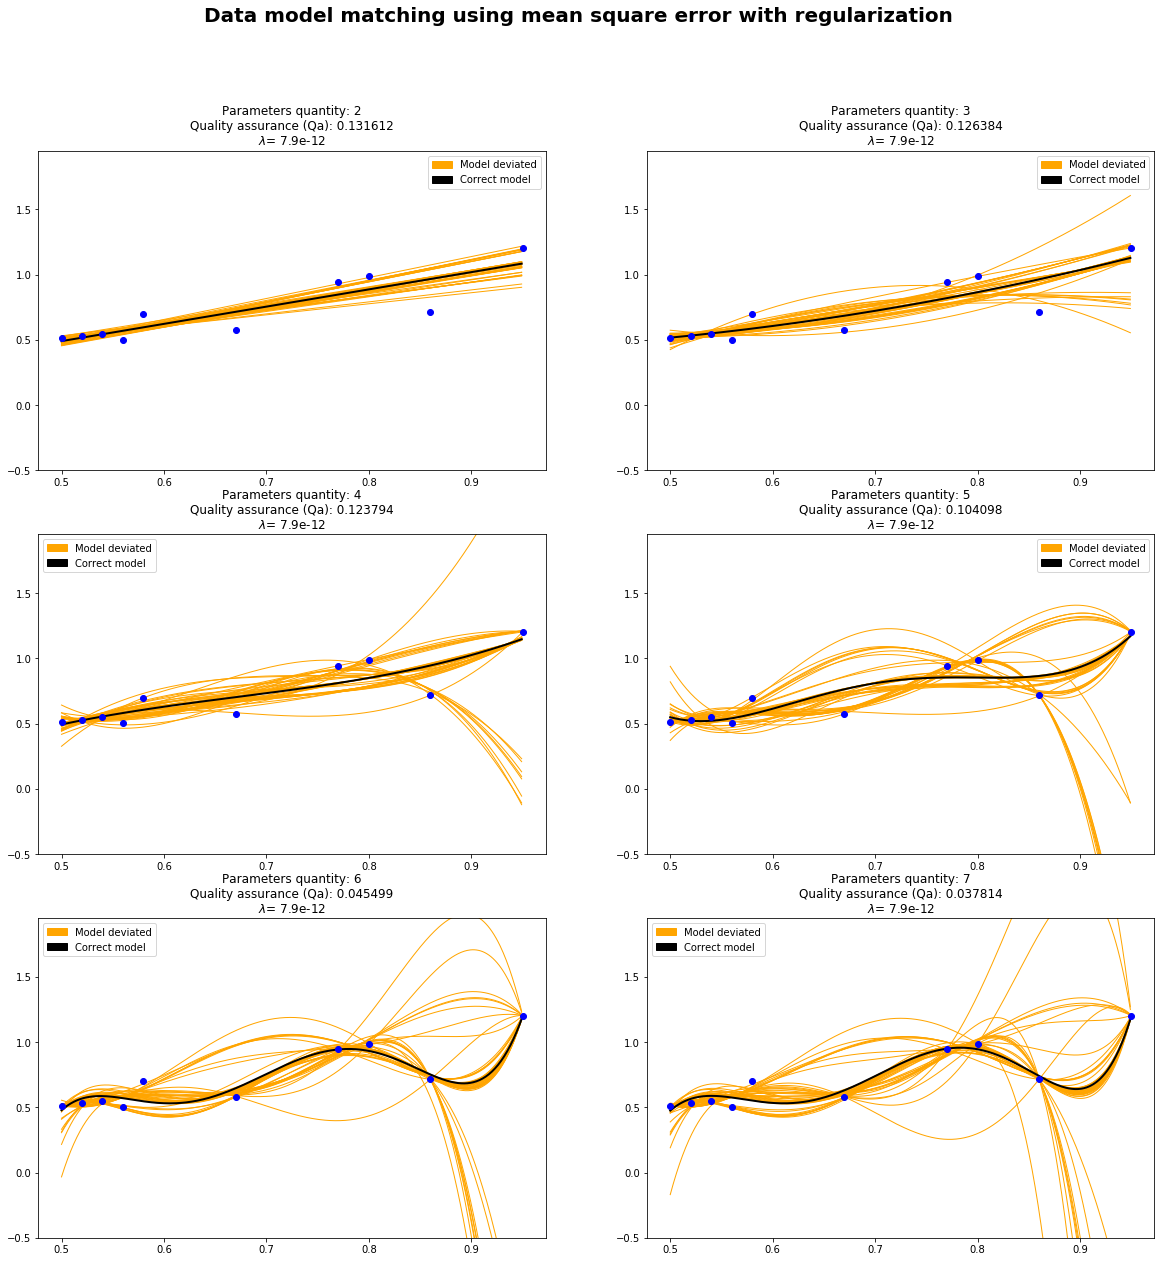

In [5]:
fig, ax = plt.subplots(nrows=PLOT_ROWS, ncols=PLOT_CELLS, figsize=(20, 20))
orange_patch = mpatches.Patch(color='orange', label='Model deviated')
black_patch = mpatches.Patch(color='black', label='Correct model')

def get_random_lambdas():
    lambdas_helper = rand.sample(range(10, 90), 20)
    lambdas = [len(lambdas_helper)]
    for i in range(len(lambdas)):
        lambdas[i] = lambdas_helper[i] * 1e-13
    return lambdas

plot_compare_results(data, get_random_lambdas())
plt.show()